In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_excel('DataScore Test.xlsx', sheet_name='Data')

data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')
data = data.drop(columns="id")
pd.set_option('display.max_columns', 10)

categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object']
data_describe = data.describe(include=[object])
binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]

data.at[data['sex'] == 'Feminine', 'sex'] = 0
data.at[data['sex'] == 'Male', 'sex'] = 1

for c in binary_columns[1:]:
    top = data_describe[c]['top']
    top_items = data[c] == top
    data.loc[top_items, c] = 0
    data.loc[np.logical_not(top_items), c] = 1
    
data_nonbinary = pd.get_dummies(data[nonbinary_columns])

data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()

data = pd.concat((data_numerical, data[binary_columns], data_nonbinary), axis=1)
data = pd.DataFrame(data, dtype=float)

X = data.drop(('marker'), axis=1)
y = data['marker']
feature_names = X.columns

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

In [2]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)
print(err_train, err_test)

0.07908163265306123 0.08333333333333333


In [3]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))
print(err_train, err_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.0770408163265306 0.0761904761904762


In [4]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))
print(err_train, err_test)

0.0 0.07380952380952381


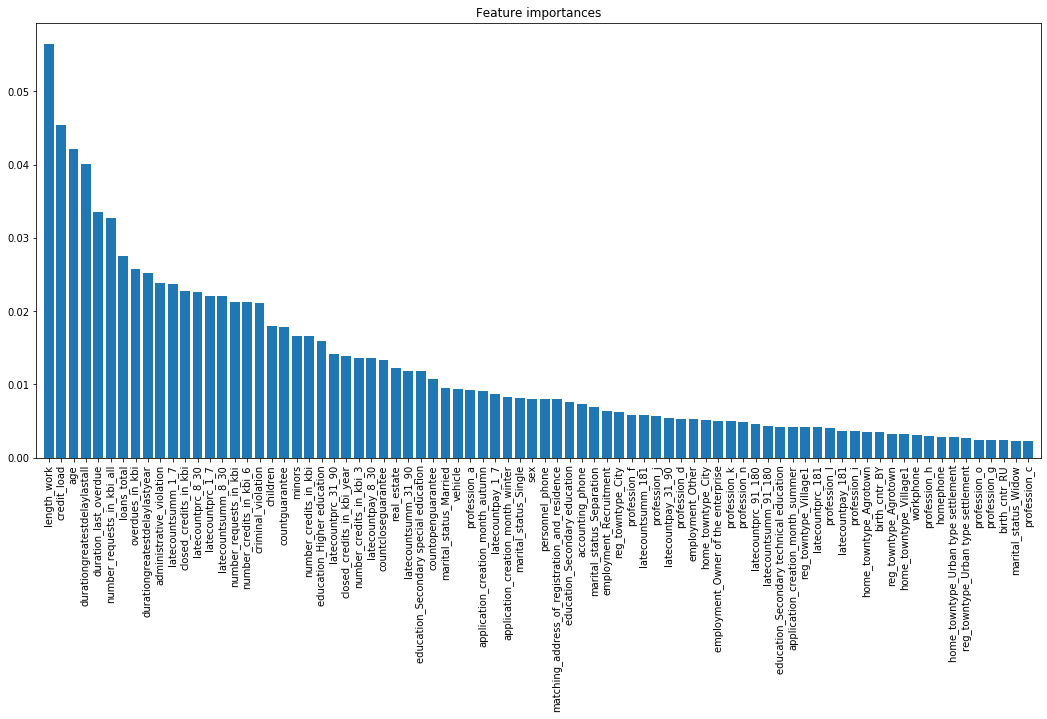

In [5]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(18, 8))
d_first = 80
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

In [6]:
best_features = indices[:48]
best_features_names = feature_names[best_features]

In [7]:
from sklearn import ensemble
gbt = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test = np.mean(y_test != gbt.predict(X_test))
print(err_train, err_test)

0.04030612244897959 0.08095238095238096


In [8]:
gbt = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
gbt.fit(X_train[best_features_names], y_train)

err_train = np.mean(y_train != gbt.predict(X_train[best_features_names]))
err_test = np.mean(y_test != gbt.predict(X_test[best_features_names]))
print(err_train, err_test)

0.04387755102040816 0.07857142857142857


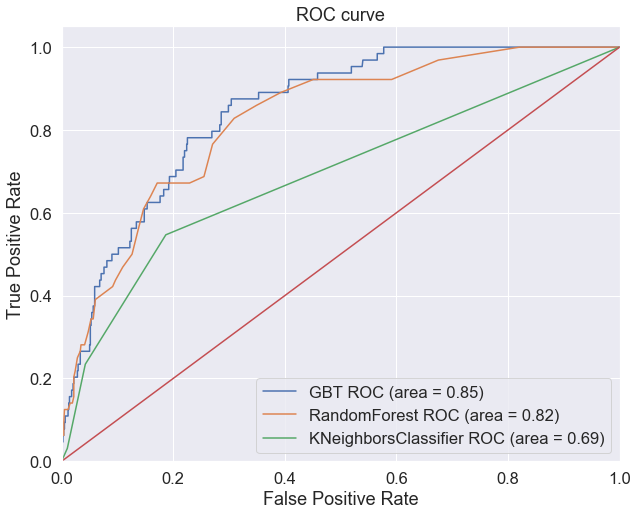

In [9]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import pylab as pl

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

models = []
models.append(rf)
models.append(knn)
models.append(gbt)

plt.figure(figsize=(10, 8))

fpr, tpr, thresholds = roc_curve(y_test, gbt.predict_proba(X_test[best_features_names])[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('GBT', roc_auc))

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandomForest', roc_auc))

fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNeighborsClassifier',roc_auc))

pl.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
pl.legend(loc="lower right")
plt.savefig("ROC.png")
plt.show()